## Importing Libraries

In [1343]:
import numpy as np
import math
import pandas as pd
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

## Reading data

In [1344]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [1345]:
df_train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [1346]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index
numeric_features

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

## Data Exploration

I will be looking at the features to determine which are most significant. To be able to compares features, non-numerical features have to be converted to numerical values. I will have to take care or missing values and determines which features can be dropped.

<Figure size 720x720 with 0 Axes>

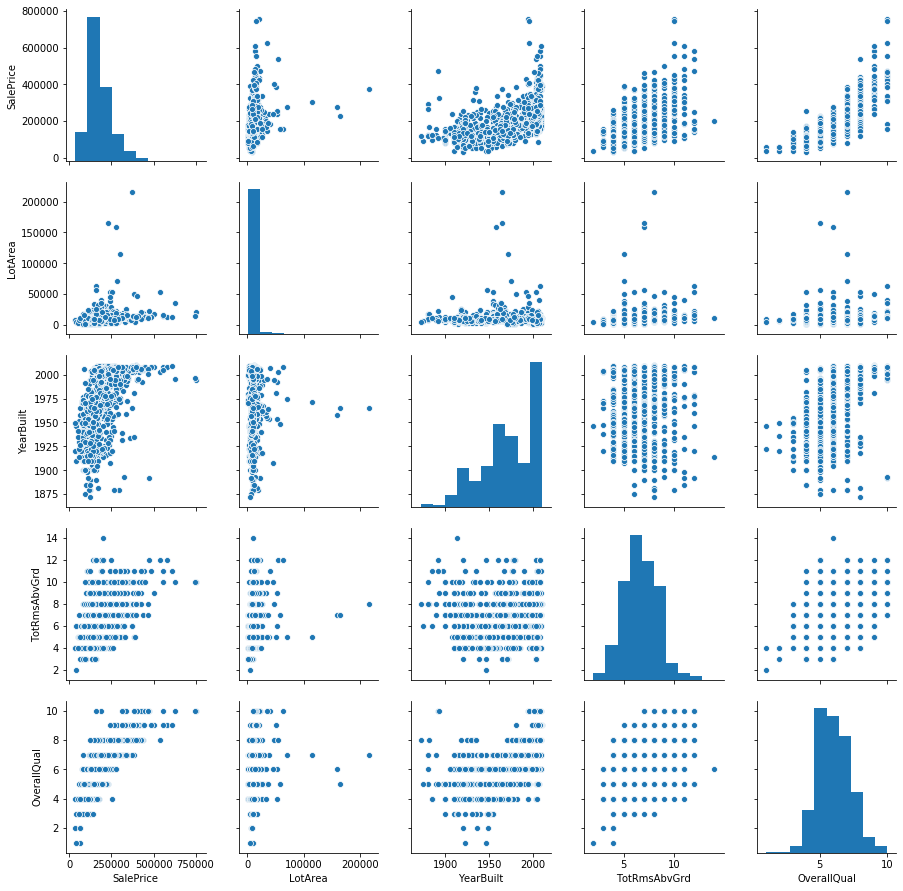

In [1347]:
features = ['SalePrice', 'LotArea', 'YearBuilt', 'TotRmsAbvGrd', 'OverallQual']

plt.figure(figsize=(10,10))
sns.pairplot(df_train[features], kind='scatter')
plt.show()

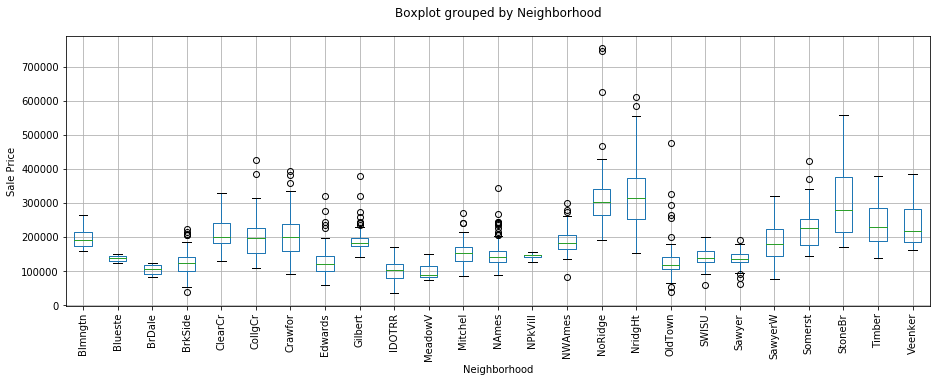

In [1348]:
df_train.boxplot(column=['SalePrice'], by='Neighborhood', figsize=(15,5))
plt.xticks(rotation=90)
plt.ylabel('Sale Price')
plt.title('')
plt.show()


### Handling Missing Values
Calculating the number and percentage of missing values in each column can give us a good idea of how they can be treated. 

In [1349]:
total = df_train.isnull().sum()
percentage = (df_train.isnull().sum()/df_train.isnull().count() *100)
dtype = df_train.dtypes
nulls = pd.concat([total,percentage,dtype],axis = 1, keys=["Total", 'Percentage','Type']).sort_values(['Total'], ascending=False)
display(nulls)

,Total,Percentage,Type
PoolQC,1453,99.520548,object
MiscFeature,1406,96.301370,object
Alley,1369,93.767123,object
Fence,1179,80.753425,object
FireplaceQu,690,47.260274,object
...,...,...,...
ExterQual,0,0.000000,object
Exterior2nd,0,0.000000,object
Exterior1st,0,0.000000,object
RoofMatl,0,0.000000,object


PoolQC seems to have the most missing values. Looking at the unique figures in the column we can tell that the null figures mean there is no pool present. The null values can therefore be replaced with 'None' to replresent this information.

In [1350]:
df_train['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [1351]:
df_train['PoolQC'].fillna(value="None", inplace = True)

Similarly, missing values in the following can also be replaced by 'None' indicating the feature does not exist.

In [1352]:
print(df_train['MiscFeature'].unique())
print(df_train['Alley'].unique())
print(df_train['Fence'].unique())
print(df_train['FireplaceQu'].unique())

[nan 'Shed' 'Gar2' 'Othr' 'TenC']
[nan 'Grvl' 'Pave']
[nan 'MnPrv' 'GdWo' 'GdPrv' 'MnWw']
[nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']


In [1353]:
df_train['MiscFeature'].fillna(value="None", inplace = True)
df_train['Alley'].fillna(value="None", inplace = True)
df_train['Fence'].fillna(value="None", inplace = True)
df_train['FireplaceQu'].fillna(value="None", inplace = True)

All garage features have the same number of missing values indicating yje houses do not have garages and therefore can also be replaces with 'None'

In [1354]:
print(df_train['GarageType'].unique())
print(df_train['GarageFinish'].unique())
print(df_train['GarageQual'].unique())
print(df_train['GarageCond'].unique())

print(df_train['GarageType'].isnull().sum())
print(df_train['GarageFinish'].isnull().sum())
print(df_train['GarageQual'].isnull().sum())
print(df_train['GarageCond'].isnull().sum())

['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
['RFn' 'Unf' 'Fin' nan]
['TA' 'Fa' 'Gd' nan 'Ex' 'Po']
['TA' 'Fa' nan 'Gd' 'Po' 'Ex']
81
81
81
81


In [1355]:
df_train['GarageType'].fillna(value="None", inplace = True)
df_train['GarageFinish'].fillna(value="None", inplace = True)
df_train['GarageQual'].fillna(value="None", inplace = True)
df_train['GarageCond'].fillna(value="None", inplace = True)

GarageYrBlt has the same number of missing values as the other garage features indicating they belong to the houses with no garage. However, this is a numerical feature and therefore the missing values will have to be replaced with a numerical value. It makes sense to replace null values with the YearBuilt values as garage would probably be built at the same time as the house itself. The non-existence of the garage can be penalised by the model with other features.

In [1356]:
print(df_train['GarageYrBlt'].isnull().sum())

81


In [1357]:
df_train['GarageYrBlt'].fillna(df_train['YearBuilt'], inplace=True)

In [1358]:
print(df_train['BsmtQual'].unique())
print(df_train['BsmtCond'].unique())
print(df_train['BsmtExposure'].unique())
print(df_train['BsmtFinType1'].unique())
print(df_train['BsmtFinType2'].unique())

print(df_train['BsmtQual'].isnull().sum())
print(df_train['BsmtCond'].isnull().sum())
print(df_train['BsmtExposure'].isnull().sum())
print(df_train['BsmtFinType1'].isnull().sum())
print(df_train['BsmtFinType2'].isnull().sum())

['Gd' 'TA' 'Ex' nan 'Fa']
['TA' 'Gd' nan 'Fa' 'Po']
['No' 'Gd' 'Mn' 'Av' nan]
['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
37
37
38
37
38


In [1359]:
df_train['BsmtExposure'].fillna(value="None", inplace = True)
df_train['BsmtFinType1'].fillna(value="None", inplace = True)
df_train['BsmtFinType2'].fillna(value="None", inplace = True)
df_train['BsmtQual'].fillna(value="None", inplace = True)
df_train['BsmtCond'].fillna(value="None", inplace = True)

In [1360]:
print(df_train['MasVnrType'].unique())

print(df_train['MasVnrType'].isnull().sum())
print(df_train['MasVnrArea'].isnull().sum())

['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
8
8


In [1361]:
df_train['MasVnrType'].fillna(value="None", inplace = True)
df_train['MasVnrArea'].fillna(value=0, inplace=True)

In [1362]:
print(df_train['Electrical'].unique())
print(df_train['Electrical'].isnull().sum())

['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
1


All houses have an electical system and therefore missing values will be replaced with the modeof the column.

In [1363]:
df_train['Electrical'].fillna(df_train['Electrical'].mode()[0], inplace=True)

LotFrontage is a continuous numerical feature and therefore missing values are replaced with the median

In [1364]:
df_train['LotFrontage'].fillna(df_train['LotFrontage'].median(), inplace=True)

In [1365]:
df_train.isnull().sum().sum()

0

No more missing values remain. We can now move on to prepare some of the ordinal features for the model.

## Handling Ordinal Features

Many of the features available indicate quality or condition. These ordinal features can be mapped with numerical values based on their relative desirability; 0 being least desirable.

In [1366]:
df_train['PoolQC'] = df_train['PoolQC'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['GarageCond'] = df_train['GarageCond'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['GarageFinish'] = df_train['GarageFinish'].map({"None":0, 'Unf':1, 'RFn':2, 'Fin':3})
df_train['FireplaceQu'] = df_train['FireplaceQu'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['GarageQual'] = df_train['GarageQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['BsmtExposure'] = df_train['BsmtExposure'].map({"None":0, 'No':1, 'Mn':2, 'Av':3, 'Gd':4})
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].map({"None":0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].map({"None":0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df_train['BsmtQual'] = df_train['BsmtQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['BsmtCond'] = df_train['BsmtCond'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['ExterQual'] = df_train['ExterQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['ExterCond'] = df_train['ExterCond'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['HeatingQC'] = df_train['HeatingQC'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})
df_train['KitchenQual'] = df_train['KitchenQual'].map({"None":0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

The following features can also be mapped similarly as it is apparent which features are more expensive and desirable.

In [1367]:
df_train['Alley'] = df_train['Alley'].map({"None":0, "Grvl":1, 'Pave':2})
df_train['Street'] = df_train['Street'].map({"Grvl":0, 'Pave':1})
df_train['CentralAir'] = df_train['CentralAir'].map({"N":0, 'Y':1})
df_train['PavedDrive'] = df_train['PavedDrive'].map({"N":0, 'P':1, 'Y':2})
df_train['LandSlope'] = df_train['LandSlope'].map({"Sev":0, 'Mod':1, 'Gtl':2})

The neighborhoods be classified as rich: 2, mid: 1 and poor: 0. This can be determined by looking at the median prices in each neighborhood. The quartiles of the SalePrice can then be used to classify the neighborhoods.

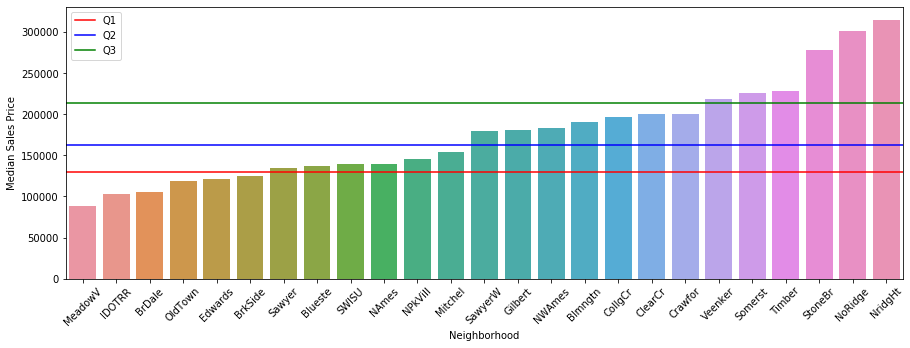

In [1368]:
median_prices = df_train.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=True)
neighborhoods = median_prices.index

Q1, Q2, Q3 = np.quantile(df_train['SalePrice'],[0.25,0.50,0.75])

plt.figure(figsize=[15,5])
ax = sns.barplot(y = median_prices, x = neighborhoods)
plt.xticks(rotation=45)
plt.xlabel('Neighborhood')
plt.ylabel('Median Sales Price')
plt.axhline(y=Q1, color='r', linestyle='-', label='Q1')
plt.axhline(y=Q2, color='b', linestyle='-', label='Q2')
plt.axhline(y=Q3, color='g', linestyle='-', label='Q3')
plt.legend()

plt.show()

In [1369]:
neghborhood_map = {}
for neighborhood in neighborhoods:
    if median_prices[neighborhood] <= Q1:
        neghborhood_map[neighborhood] = 0
    elif median_prices[neighborhood] >= Q3:
        neghborhood_map[neighborhood] = 2
    else:
        neghborhood_map[neighborhood] = 1 

df_train['Neighborhood'] = df_train['Neighborhood'].map(neghborhood_map)

In [1370]:
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index

## Converting features from numeric to categoric

Some numeric features are not directly proportional to SalesPrice. A house sold later may not necessarily be priced higher. These fatures will have to be categorized.

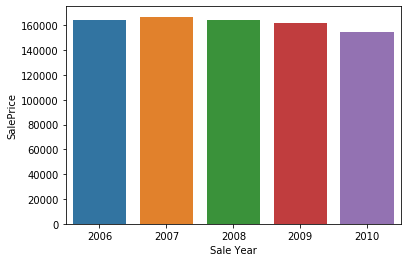

In [1371]:
sns.barplot(y = df_train.groupby('YrSold')['SalePrice'].median(), x = df_train['YrSold'].unique())
plt.xlabel('Sale Year')
plt.show()

df_train['YrSold'] = df_train['YrSold'].astype(object)

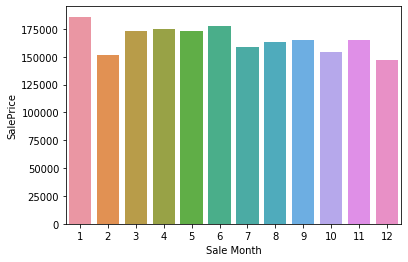

In [1372]:
sns.barplot(y = df_train.groupby('MoSold')['SalePrice'].median(), x = df_train['MoSold'].unique())
plt.xlabel('Sale Month')
plt.show()

df_train['MoSold'] = df_train['MoSold'].astype(object)

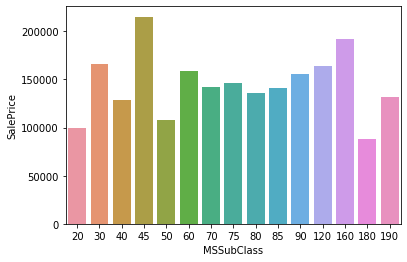

In [1373]:
sns.barplot(y = df_train.groupby('MSSubClass')['SalePrice'].median(), x = df_train['MSSubClass'].unique())
plt.xlabel('MSSubClass')
plt.show()

df_train['MSSubClass'] = df_train['MSSubClass'].astype(object)

In [1374]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index

## Creating new features

New features can be created to extract more information from the data and consequently drop features that may not be very helpful.

The age of the house can be calculated as the time between when it was remodelled and the year it was sold. If no remodelling was done, YearRemodAdd = YearBuilt. A new feature can also be added to indicate whether or not a house was remodelled to ensure that information is not lost. Additionally another feature can indicate if a house is brand new.

In [1375]:
df_train[['YearRemodAdd','YearBuilt']].head()

,YearRemodAdd,YearBuilt
0,2003,2003
1,1976,1976
2,2002,2001
3,1970,1915
4,2000,2000


In [1376]:
for i in df_train[['YearRemodAdd','YearBuilt']]:
    print(i)

YearRemodAdd
YearBuilt


In [1377]:
df_train['Age'] = (df_train['YrSold'] - df_train['YearBuilt']).astype(int)
df_train['Remoded'] = (df_train['YearRemodAdd'] - df_train['YearBuilt'] != 0).map({False:0, True:1})
df_train['IsNew'] = (df_train['YearBuilt'] == df_train['YrSold']).map({False:0, True:1})

TotalArea and TotBath can help incorporate data from several feautures which individually may not tell us a whole lot.

In [1378]:
df_train['TotalArea'] = (df_train['GarageArea']
                         + df_train['GrLivArea'] + df_train['TotalBsmtSF'])      

df_train['TotBath'] = (df_train['FullBath'] + df_train['HalfBath']*0.5 
                        + df_train['BsmtFullBath'] + df_train['BsmtHalfBath']*0.5)

Several features can now be eliminated as they are used to create new features

In [1379]:
df_train = df_train.drop(['FullBath','HalfBath','YearBuilt','YearRemodAdd','Id','GrLivArea',\
                          'TotalBsmtSF','GarageArea','BsmtFullBath','BsmtHalfBath'],1)

In [1380]:
numeric_features = df_train.dtypes[df_train.dtypes != "object"].index

## Feature correlation

We can now take a look at how these numeric features correlate with SalePrice

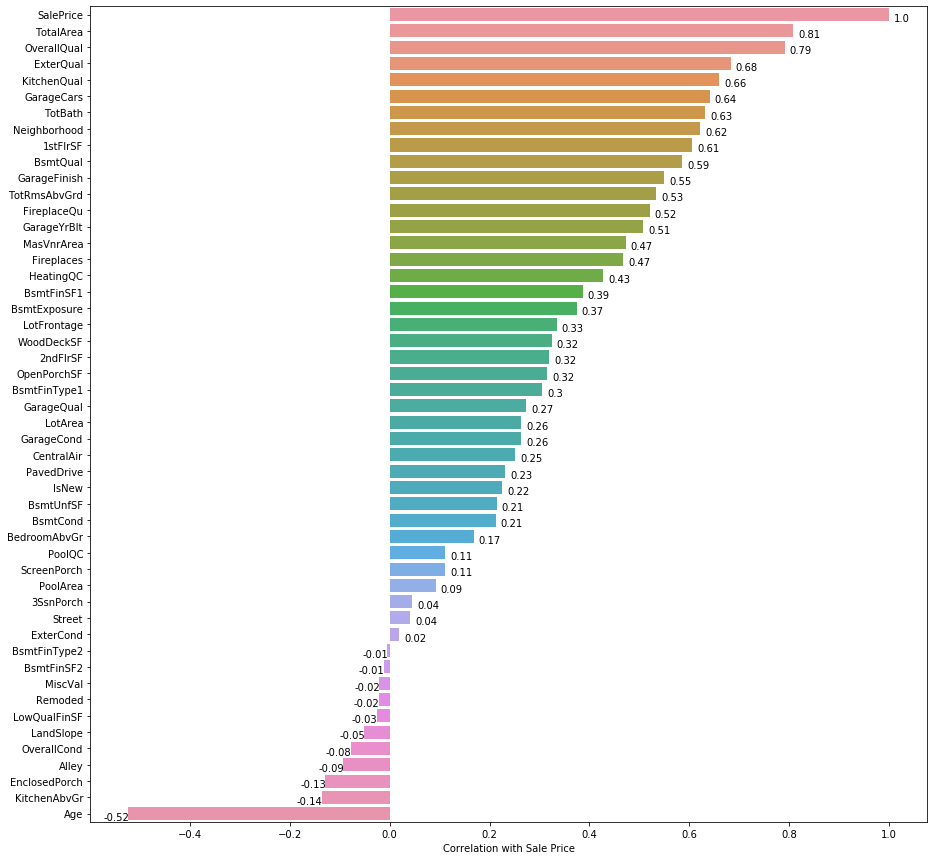

In [1381]:
corr_matrix = df_train.corr()
corr_matrix = corr_matrix['SalePrice'].sort_values(ascending=False)
strong_attributes = [i for i in corr_matrix.index if (corr_matrix.loc[i] >= 0.5 or corr_matrix.loc[i] <= -0.5) and i != 'SalePrice']
attributes = corr_matrix.drop('SalePrice').index

plt.figure(figsize=[15,15])
ax = sns.barplot(y = corr_matrix.index, x = corr_matrix)
plt.xlabel('Correlation with Sale Price')

for p in ax.patches:
    if p.get_width() > 0:
        _x = p.get_x() + p.get_width() + float(0.01)
    else:
        _x = p.get_x() + p.get_width() - float(0.05)
    _y = p.get_y() + p.get_height()
    value = round(float(p.get_width()),2)
    ax.text(_x, _y, value, ha="left")
        
plt.show()

We can use a heatmap to look at intercorrelation between strong features to ensure they are not too high.

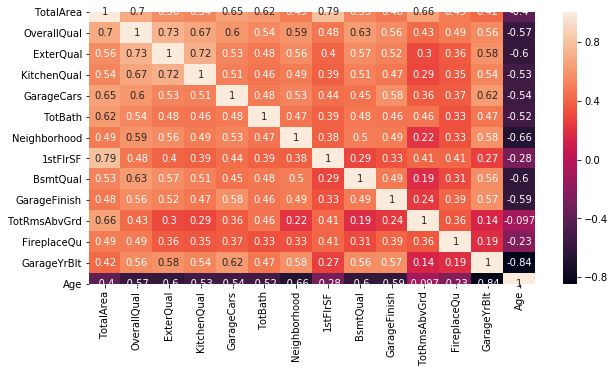

In [1382]:
plt.figure(figsize=[10,5])
sns.heatmap(df_train[strong_attributes].corr(), annot=True)
plt.show()

In [1383]:
for feature in numeric_features:
    df_train[feature] = np.log1p(df_train[feature])

In [1384]:
categorical_features = df_train.dtypes[df_train.dtypes == "object"].index
print(categorical_features)

Index(['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType',
       'Fence', 'MiscFeature', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')


In [1385]:
data = pd.get_dummies(df_train, columns=categorical_features)

In [1386]:
for feature in data.columns:
    if data.astype(bool)[feature].sum(axis=0) < 100:
        data = data.drop(feature, 1)

In [1387]:
from sklearn.preprocessing import StandardScaler

In [1388]:
X = data.loc[:, data.columns != 'SalePrice']
Y = data['SalePrice']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [1389]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [1390]:
from sklearn.linear_model import LinearRegression

LR = LinearRegression()

LR.fit(X_train_scaled, Y_train)

LR_pred = LR.predict(X_test_scaled)

print("RMSE:", np.sqrt(mean_squared_error(Y_test, LR_pred)))
print("R2 score:",r2_score(Y_test, LR_pred))

RMSE: 0.13424544054269605
R2 score: 0.9034256318839209


In [1391]:
from sklearn.linear_model import RidgeCV

alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80, 100, 120, 200, 500, 1000]

ridgeCV = RidgeCV(alphas=alphas, cv=4)
ridgeCV.fit(X_train_scaled, Y_train)
ridgeCV_pred = ridgeCV.predict(X_test_scaled)

print("RMSE:",np.sqrt(mean_squared_error(Y_test, ridgeCV_pred)))
print("R2 score:",r2_score(Y_test, ridgeCV_pred))
print("Alpha:",ridgeCV.alpha_)
print("Number of non-zero coefficients:",(ridgeCV.coef_!=0).sum())

RMSE: 0.13631672975084824
R2 score: 0.9004225262913695
Alpha: 200.0
Number of non-zero coefficients: 103


In [1392]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005, 0.001, 0.01])

lassoCV = LassoCV(alphas=alphas2, max_iter=5e4, cv=4)
lassoCV.fit(X_train_scaled, Y_train)
lassoCV_pred = ridgeCV.predict(X_test_scaled)

print("RMSE:",np.sqrt(mean_squared_error(Y_test, lassoCV_pred)))
print("R2 score:",r2_score(Y_test, lassoCV_pred))
print("Alpha:",lassoCV.alpha_)
print("Number of non-zero coefficients:",(lassoCV.coef_!=0).sum())

RMSE: 0.13631672975084824
R2 score: 0.9004225262913695
Alpha: 0.001
Number of non-zero coefficients: 77


In [1393]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train_scaled, Y_train)

elasticNetCV_pred = elasticNetCV.predict(X_test_scaled)

print("RMSE:",np.sqrt(mean_squared_error(Y_test, elasticNetCV_pred)))
print("R2 score:",r2_score(Y_test, elasticNetCV_pred))
print("Number of non-zero coefficients:",(elasticNetCV.coef_!=0).sum())

RMSE: 0.13453632730499065
R2 score: 0.903006658388286
Number of non-zero coefficients: 48


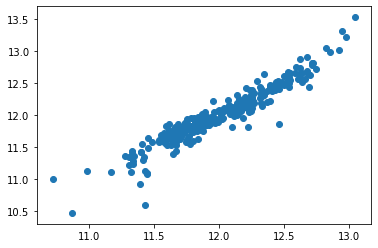

In [1394]:
plt.scatter(LR_pred,Y_test)

Linear regression has the highest R2 score and lowest RMSE value 